# Week 8: Spatial networks in context

In [1]:
# Some new libraries: they should already
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString

# A new library to install in your environment
# conda install -c conda-forge spaghetti (if using conda)
import spaghetti

# Our usual libraries
import os
import glob

import pandas as pd
import networkx
import osmnx

from matplotlib import pyplot as plt

/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((-0.14197 51.51512, -0.14190 51.51525...   51.516365   51.509966   

   bbox_east  bbox_west   place_id osm_type     osm_id        lat       lon  \
0  -0.129378  -0.141829  178819807      way  303976093  51.514065 -0.135049   

                                        display_name  class    type  \
0  Soho, Islington, London, Greater London, Engla...  place  suburb   

   importance  
0    0.928698  


/Users/congrendai/miniconda3/envs/NDA_CW2/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


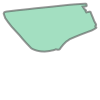

In [4]:
# Choose a place whose crimes we will analyse with respect to its street network
PLACE_OF_INTEREST = "Soho, London, United Kingdom"
# Get the geographical area of Soho from OpenStreetMap as a GeoDataFrame
soho_area = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=10)
# From this take the polygon that defines Soho's boundary
soho_polygon = soho_area['geometry'][0]
soho_polygon

We will read in the London crime points from September 2021, downloaded from https://data.police.uk/data/ (you need to do this manually, but you can also implement your own script to fetch the data automatically according to certain filters). When you open the page, make sure you select the right date interval (the one you are interested in), and limit the choice to the *"Metropolitan Police Service"* (under *forces*). Feel free to experiment with other data, but make sure to adapt the macro/variables below when you read the CSV files you downloaded.

PS: the creation and the download of your own dataset from the .gov website can take some time!

In [3]:
# Here, I assume that you downloaded or moved the crime data in `../data/crimes/`
CRIMES_DIR = "../data/crimes"  # then, one subfolder for each YEAR-MONTH
# We will only use the longitude and latitude columns in the data
USE_COLS = ['Longitude', 'Latitude']

# We need to load and collate all CSV files into a single dataframe
months_df = [pd.read_csv(csv_file, usecols=USE_COLS) \
                for path, subdir, _ in os.walk(CRIMES_DIR) \
                 for csv_file in glob.glob(os.path.join(path, "*.csv"))]

print("Found {} CSV files in {}".format(len(months_df), CRIMES_DIR))

crimes_df = pd.concat(months_df, axis=0, ignore_index=True)
print("Total no. of crimes loaded: {}".format(len(crimes_df)))

Found 6 CSV files in ../data/crimes
Total no. of crimes loaded: 551353


In [4]:
# Some crimes do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_crimes = crimes_df.dropna(subset=['Longitude', 'Latitude'])
print("Total no. of located crimes filtered: {}".format(len(located_crimes)))

Total no. of located crimes filtered: 538030


In [5]:
# XXX Run this cell to process  network pattern analysis
located_crimes = located_crimes.sample(frac=.3)
len(located_crimes)  # to double-check

161409

In [6]:
# Translate to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
crime_points = GeoDataFrame(geometry=[Point(xy) for xy in zip(
    located_crimes.Longitude, located_crimes.Latitude)])

print("Total no. of located crimes filtered: {}".format(len(crime_points)))

crime_points

Total no. of located crimes filtered: 161409


,geometry
0,POINT (-0.10724 51.56358)
1,POINT (-0.05881 51.63092)
2,POINT (-0.13974 51.53541)
3,POINT (-0.47589 51.60673)
4,POINT (-0.29837 51.55106)
...,...
161404,POINT (-0.13800 51.51507)
161405,POINT (-0.43283 51.44839)
161406,POINT (-0.37274 51.49935)
161407,POINT (-0.10705 51.37899)


In [7]:
# Filter the crime points to just those within Soho, as defined by the polygon found earlier
soho_crimes = crime_points[crime_points.geometry.within(soho_polygon)]
soho_crimes

,geometry
93,POINT (-0.13630 51.51573)
166,POINT (-0.12959 51.51385)
180,POINT (-0.13282 51.51429)
234,POINT (-0.13528 51.51073)
335,POINT (-0.13412 51.51273)
...,...
161328,POINT (-0.13439 51.51397)
161331,POINT (-0.14084 51.51468)
161345,POINT (-0.13744 51.51052)
161398,POINT (-0.13752 51.51242)


In [8]:
# Get the network of streets in Soho
soho_graph = osmnx.graph_from_place(PLACE_OF_INTEREST)
soho_area = osmnx.project_gdf(soho_area).unary_union.area
osmnx.basic_stats(soho_graph, area=soho_area)

{'n': 263,
 'm': 538,
 'k_avg': 4.091254752851711,
 'edge_length_total': 17638.397999999997,
 'edge_length_avg': 32.78512639405204,
 'streets_per_node_avg': 2.726235741444867,
 'streets_per_node_counts': {0: 0, 1: 57, 2: 3, 3: 159, 4: 43, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.21673003802281368,
  2: 0.011406844106463879,
  3: 0.6045627376425855,
  4: 0.1634980988593156,
  5: 0.0038022813688212928},
 'intersection_count': 206,
 'street_length_total': 11655.137999999992,
 'street_segment_count': 344,
 'street_length_avg': 33.881215116279044,
 'circuity_avg': 1.0337874905150541,
 'self_loop_proportion': 0.0,
 'node_density_km': 622.5240949429472,
 'intersection_density_km': 487.60442417584454,
 'edge_density_km': 41750.2956319144,
 'street_density_km': 27587.848801844662}

In [9]:
# We can see that the nodes are specified by x, y, coordinates
list(soho_graph.nodes(data=True))[0:10]

[(107324, {'y': 51.5156469, 'x': -0.1324402, 'street_count': 4}),
 (107326, {'y': 51.5151371, 'x': -0.1327658, 'street_count': 4}),
 (107328, {'y': 51.5148204, 'x': -0.1323095, 'street_count': 3}),
 (107812, {'y': 51.5113932, 'x': -0.1343278, 'street_count': 4}),
 (107820, {'y': 51.5107007, 'x': -0.1355377, 'street_count': 3}),
 (107821, {'y': 51.5103745, 'x': -0.1352468, 'street_count': 3}),
 (108059, {'y': 51.5105263, 'x': -0.137384, 'street_count': 4}),
 (108060, {'y': 51.5108324, 'x': -0.1368041, 'street_count': 4}),
 (108061, {'y': 51.5104722, 'x': -0.1366159, 'street_count': 5}),
 (108070, {'y': 51.5121078, 'x': -0.1382034, 'street_count': 4})]

In [10]:
# And the edges are tuples of start node, end node and a dictionary with attributes including geometry
list(soho_graph.edges(data=True))[0:3]

[(107324,
  5877163201,
  {'osmid': 59207650,
   'name': 'Soho Street',
   'highway': 'residential',
   'maxspeed': '20 mph',
   'oneway': False,
   'length': 53.861}),
 (107324,
  1694551556,
  {'osmid': 4082521,
   'oneway': True,
   'name': 'Soho Square',
   'highway': 'residential',
   'maxspeed': '20 mph',
   'length': 82.281,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fcd905e2850>}),
 (107324,
  1080601938,
  {'osmid': 395757466,
   'highway': 'footway',
   'oneway': False,
   'length': 12.099,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fcd905e27c0>})]

In [11]:
# Some edges (roads in Soho) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = networkx.get_node_attributes(soho_graph, 'x')
y_values = networkx.get_node_attributes(soho_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(soho_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

graph_with_geometries[0:4]

[(107324,
  5877163201,
  {'osmid': 59207650,
   'name': 'Soho Street',
   'highway': 'residential',
   'maxspeed': '20 mph',
   'oneway': False,
   'length': 53.861,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fcd909bfac0>}),
 (107324,
  1694551556,
  {'osmid': 4082521,
   'oneway': True,
   'name': 'Soho Square',
   'highway': 'residential',
   'maxspeed': '20 mph',
   'length': 82.281,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fcd905e2850>}),
 (107324,
  1080601938,
  {'osmid': 395757466,
   'highway': 'footway',
   'oneway': False,
   'length': 12.099,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fcd905e27c0>}),
 (107326,
  1080601933,
  {'osmid': 44604953,
   'highway': 'footway',
   'oneway': False,
   'length': 10.120999999999999,
   'geometry': <shapely.geometry.linestring.LineString at 0x7fcd905e28b0>})]

In [12]:
# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
roads_geodataframe

,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,access,tunnel,service
0,59207650,Soho Street,residential,20 mph,False,53.861,"LINESTRING (-0.13244 51.51565, -0.13274 51.51609)",NaN,NaN,NaN,NaN
1,4082521,Soho Square,residential,20 mph,True,82.281,"LINESTRING (-0.13244 51.51565, -0.13188 51.515...",NaN,NaN,NaN,NaN
2,395757466,NaN,footway,NaN,False,12.099,"LINESTRING (-0.13244 51.51565, -0.13241 51.515...",NaN,NaN,NaN,NaN
3,44604953,NaN,footway,NaN,False,10.121,"LINESTRING (-0.13277 51.51514, -0.13271 51.515...",NaN,NaN,NaN,NaN
4,66151802,Soho Square,residential,20 mph,True,86.330,"LINESTRING (-0.13277 51.51514, -0.13301 51.515...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
533,"[1064371136, 674171733]",Diadem Court,"[footway, pedestrian]",NaN,False,37.345,"LINESTRING (-0.13410 51.51520, -0.13368 51.515...",NaN,NaN,NaN,NaN
534,"[1064371137, 1064371138, 674171733]",Diadem Court,"[footway, pedestrian]",NaN,False,7.238,"LINESTRING (-0.13410 51.51520, -0.13411 51.515...",NaN,no,NaN,NaN
535,1064371139,Diadem Court,footway,NaN,False,8.967,"LINESTRING (-0.13410 51.51520, -0.13409 51.515...",NaN,NaN,NaN,NaN
536,4082563,Greek Street,residential,20 mph,True,90.449,"LINESTRING (-0.13099 51.51423, -0.13047 51.51348)",NaN,NaN,NaN,NaN


In [13]:
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
soho_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<AxesSubplot:>

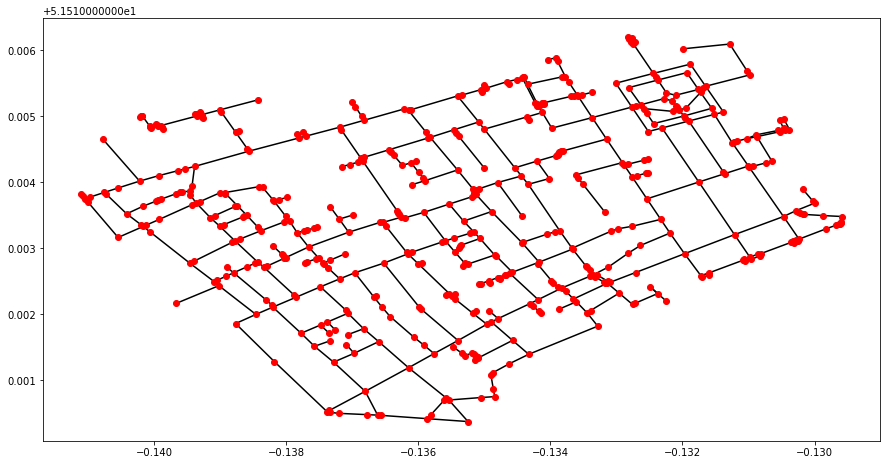

In [14]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
nodes_df, edges_df = spaghetti.element_as_gdf(
    soho_points_graph, vertices=True, arcs=True)

base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [15]:
# We will now snap the Soho located crimes we extracted earlier, i.e. position them at the closest point on the closest road
soho_points_graph.snapobservations(soho_crimes, 'crimes')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    soho_points_graph.pointpatterns["crimes"].points[0]["coordinates"],
    soho_points_graph.pointpatterns["crimes"].snapped_coordinates[0]
))

observation 1
true coords:	(-0.136304, 51.515727)
snapped coords:	(-0.1362135, 51.5151089)


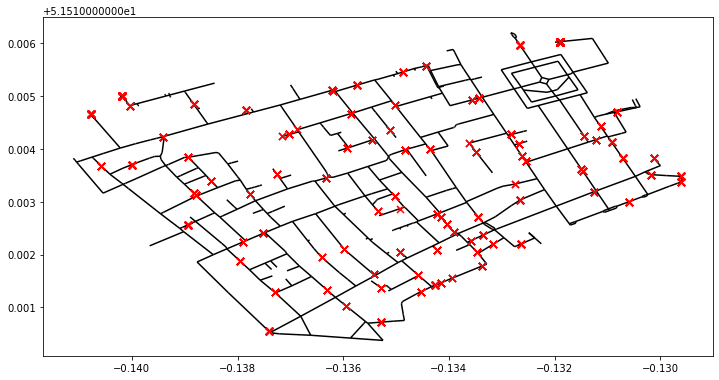

In [16]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_crimes=spaghetti.element_as_gdf(
    soho_points_graph, pp_name='crimes', snapped=True)

# Plot these on the road network
snapped_crimes.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

<AxesSubplot:>

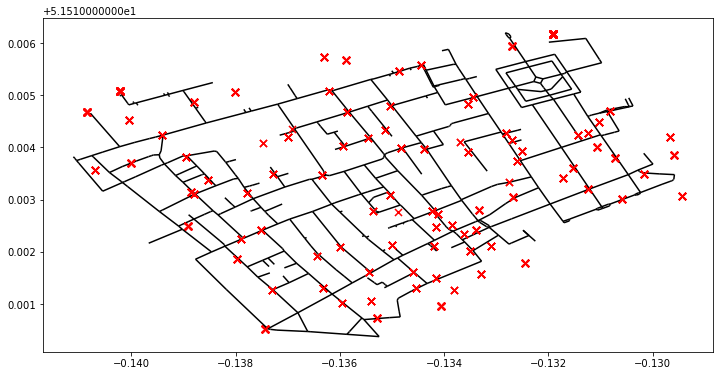

In [17]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_crimes=spaghetti.element_as_gdf(
    soho_points_graph, pp_name='crimes', snapped=False)

# Plot these on the road network
observed_crimes.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

# plt.savefig('crime_observations_unsnapped')

Note that the key variable we will use from the above code is `soho_points_graph`, the `spaghetti` network representation of the Soho streets with crime points plotted onto it.

## Network point pattern analysis

We now focus on point pattern analysis on a `spatial` network. We add a new import on top of those used before: `esda`, another PySal spatial analysis library which helps us measure spatial autocorrelation.

In [18]:
# Ps: you should already have esda in your env; if not, just run:
#!conda install -c conda-forge esda
import esda

Now we will perform this week's analysis, first using the K-function analysis provided by `spaghetti`. For each point, the density of other points within a series of bands at increasing steps of distance is calculated, where the number of bands is given by variable **nsteps**. This is then averaged across points to get the K value. Alongside this, it is simulated what density would be seen under instances of complete spatial randomness of distribution of points on the network (a Monte Carlo simulation). As each instance of a random placing of points will be different, it runs this simulation a number of times, given by parameter **permutations**. Looking at the range of values produced by the simulations gives us an approximation of the lower and upper bounds of density expected with a random distribution: if the real values don't fall in these bounds, we may conclude they are not random (either more clustered or more uniform than expected).

In [19]:
kres = soho_points_graph.GlobalAutoK(
    soho_points_graph.pointpatterns["crimes"],
    nsteps=50, permutations=100
)

The result of the analysis is held in an object, `kres`, with multiple attributes. The important ones are listed below. Attribute `lam` is the density of points on the network as a whole (the lambda value). This should be a high number for our points, which sounds very dense but remember that our coordinates are longitude/latitude degrees: if we had converted our reference system to metres, it would be a much lower density value. The `axis` attribute is the list of distances at which density is measured, i.e. the bands. The remaining attributes listed all return a list of K-function values, one for each distance band: `observed` is for our real data, `upperenvelope` and `lowerenvelope` give the maximum and minimum values found in the simulation, while `sim` is the data from all the simulations: a list of lists of K-function values.

In [20]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 21816.78683205101


In [21]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.00026976 0.00053953 0.00080929 0.00107905 0.00134882
 0.00161858 0.00188834 0.00215811 0.00242787 0.00269763 0.0029674
 0.00323716 0.00350692 0.00377669 0.00404645 0.00431621 0.00458598
 0.00485574 0.0051255  0.00539527 0.00566503 0.00593479 0.00620456
 0.00647432 0.00674408 0.00701385 0.00728361 0.00755337 0.00782314
 0.0080929  0.00836266 0.00863243 0.00890219 0.00917196 0.00944172
 0.00971148 0.00998125 0.01025101 0.01052077 0.01079054 0.0110603
 0.01133006 0.01159983 0.01186959 0.01213935 0.01240912 0.01267888
 0.01294864 0.01321841]


We can now plot the above data so that we can judge it visually. The code below will create a plot with three lines: the observed K-function values as the band distance increases, and the upper and lower bounds from the simulations.

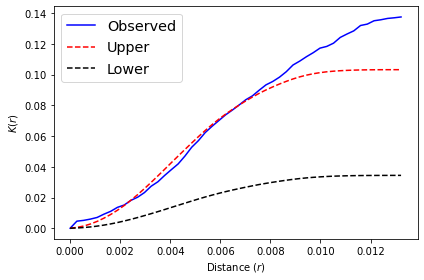

In [22]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

The above seems to show that, at all distances and increasing as distance increases, the points are more clustered than would be expected.

However, we need to be aware that the crime data is not showing the precise locations of crimes but just what street each crime occurred on. Because of this, it is perhaps more meaningful to look at crime counts per street. We will then ask whether these counts are spatially autocorrelated on the network space. To do this, we first get the pattern of crime points snapped to the network, and then get the count of points per each street (network edge).

In [23]:
# Get snapped point pattern 
pointpat = soho_points_graph.pointpatterns['crimes']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = soho_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)

In [24]:
counts

{(100, 394): 36,
 (125, 400): 75,
 (366, 367): 30,
 (21, 23): 59,
 (74, 75): 20,
 (91, 336): 133,
 (34, 188): 16,
 (71, 73): 15,
 (230, 231): 47,
 (273, 274): 14,
 (404, 409): 30,
 (36, 191): 40,
 (268, 269): 6,
 (459, 464): 231,
 (13, 14): 147,
 (33, 190): 8,
 (246, 247): 5,
 (248, 249): 16,
 (436, 437): 58,
 (145, 146): 86,
 (41, 42): 6,
 (115, 116): 182,
 (291, 292): 253,
 (163, 281): 18,
 (499, 500): 116,
 (94, 97): 63,
 (493, 494): 6,
 (0, 1): 103,
 (149, 153): 71,
 (120, 121): 21,
 (25, 26): 102,
 (266, 267): 14,
 (178, 466): 48,
 (11, 89): 72,
 (66, 310): 27,
 (167, 168): 50,
 (56, 57): 40,
 (169, 170): 37,
 (104, 269): 5,
 (137, 512): 43,
 (398, 399): 42,
 (234, 235): 49,
 (147, 219): 31,
 (341, 342): 9,
 (36, 196): 9,
 (295, 296): 17,
 (380, 390): 13,
 (46, 47): 26,
 (195, 196): 31,
 (349, 350): 14,
 (52, 54): 34,
 (271, 272): 6,
 (128, 129): 37,
 (455, 456): 37,
 (119, 121): 14,
 (350, 351): 2,
 (108, 112): 30,
 (85, 86): 34,
 (34, 186): 5,
 (175, 370): 28,
 (13, 16): 11,
 (1

Next, we need our spatial weights. As discussed in lesson, this is the edge adjacency matrix, i.e. a matrix where the edges are the rows and columns and there is a 1 wherever the edges are connected by a node, 0 otherwise.

In [25]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = soho_points_graph.w_network

As a final preparation step for running the analysis, we need to put the edge counts in a list in the same order as the weights. This is just required for the autocorrelation calculation function we will use.

In [26]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

Now we can calculate Moran's I using the crime count values and weights we've prepared.

In [27]:
moran = esda.moran.Moran(values, weights)
moran.I

-0.04224435893591954

Our value for the statistic needs to be interpreted against a reference distribution under the null of CSR. PySAL uses a similar approach as we saw in the join count analysis: random spatial permutations.

In [28]:
moran.p_sim

0.01

This should return a value close to zero, possibly implying no detectable autocorrelation. If you check the weights list after running the above method, you will notice that the **weights** have been row normalised: this is a step in the process of calculating Moran's I. We can check the significance of this compared to the simulation by looking at `moran.p_sim`, the p-value compared to the simulated case. This gives a value > 0.005, meaning we have not proven the case for autocorrelation between crime values, although we observe a mild tendency towards dispersion (as `moran.I` is a small negative value and 0.005 < `moran.psim` < 0.05).

We can get other relevant values as attributes of the **moran** result object, such as those below. `EI` is the expected value of Moran's I given the number of points plotted, i.e. the value of Moran's I that would be most indicative of complete randomness, which is -1/n-1. `EI_sim` gives the average Moran's I value from the simulations.

In [29]:
moran.EI
moran.EI_sim

print(moran.EI)

-0.001644736842105263


Text(0.5, 0, "Moran's I")

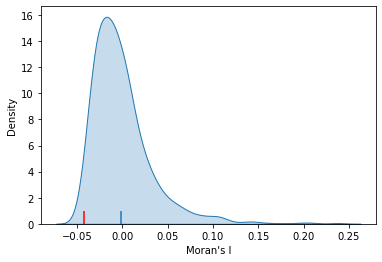

In [30]:
import seaborn as sns

sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

The full attributes available, including z scores, are listed at https://pysal.org/esda/generated/esda.Moran.html

Taking our K-function analysis and spatial autocorrelation analysis together, it suggests that crimes in Soho were independent of each other (so no significant autocorrelation) but that the external environment has an influence on crime, e.g. buildings on the street network, causing them to be clustered (so high K-function values).

In [31]:
moran.z_norm
moran.z_sim

-1.2199310324870218